<a href="https://colab.research.google.com/github/marcello-turri/population_forecasting/blob/main/Population_growth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from kerastuner.tuners import RandomSearch
import keras_tuner

<ipython-input-2-278d7c2887dd>:7: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [ ]:
df = pd.read_csv("/content/POP.csv",
                 parse_dates=["date"],
                 index_col=["date"]) #set Date to become index
df.head()

,realtime_start,value,realtime_end
date,,,
1952-01-01,2019-12-06,156309.0,2019-12-06
1952-02-01,2019-12-06,156527.0,2019-12-06
1952-03-01,2019-12-06,156731.0,2019-12-06
1952-04-01,2019-12-06,156943.0,2019-12-06
1952-05-01,2019-12-06,157140.0,2019-12-06


In [ ]:
df = df[['value']]
df

,value
date,
1952-01-01,156309.000
1952-02-01,156527.000
1952-03-01,156731.000
1952-04-01,156943.000
1952-05-01,157140.000
...,...
2019-08-01,329591.333
2019-09-01,329785.872
2019-10-01,329982.035


In [ ]:
def train_val_test_split(X, y, test_size=0.2):
  X_train = np.array(X[:int(len(X) * ( 1 - test_size ))])
  y_train = np.array(y[:int(len(y) * ( 1 - test_size ))])
  X_test = np.array(X[int(len(X) * ( 1 - test_size )):])
  y_test = np.array(y[int(len(y) * ( 1 - test_size )):])
  return X_train, y_train, X_test, y_test

In [ ]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Population")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)
     

In [ ]:
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()}

In [ ]:
# HYPERPARAMETERS

HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 10 # use a week worth of timesteps to predict the horizon


In [ ]:
def get_labelled_windows(x, horizon):
  return x[:, :-horizon], x[:, -horizon:]

In [ ]:
def make_windows(x, window_size=7, horizon=1):
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
  windowed_array = x[window_indexes]
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [ ]:
values = np.array(df.reset_index()['value'])
timestamps = np.array(np.array(df.index))

In [ ]:
values[:10]

array([156309., 156527., 156731., 156943., 157140., 157343., 157553.,
       157798., 158053., 158306.])

In [ ]:
timestamps[:10]

array(['1952-01-01T00:00:00.000000000', '1952-02-01T00:00:00.000000000',
       '1952-03-01T00:00:00.000000000', '1952-04-01T00:00:00.000000000',
       '1952-05-01T00:00:00.000000000', '1952-06-01T00:00:00.000000000',
       '1952-07-01T00:00:00.000000000', '1952-08-01T00:00:00.000000000',
       '1952-09-01T00:00:00.000000000', '1952-10-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [ ]:
full_windows, full_labels = make_windows(values, window_size=WINDOW_SIZE, horizon=HORIZON)

In [ ]:
full_windows[0]

array([156309., 156527., 156731., 156943., 157140., 157343., 157553.,
       157798., 158053., 158306.])

In [ ]:
full_labels[0]

array([158451.])

In [ ]:
values[:11]

array([156309., 156527., 156731., 156943., 157140., 157343., 157553.,
       157798., 158053., 158306., 158451.])

In [ ]:
train_windows, train_labels, test_windows, test_labels = train_val_test_split(full_windows,
                                                                              full_labels,
                                                                              test_size=0.2)
len(train_windows), len(train_labels),len(test_windows), len(test_labels)

(644, 644, 162, 162)

In [ ]:
# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            monitor='val_mae',
                                            mode='min',
                                            save_best_only=True) # save only the best model to file

In [ ]:
def build_model():
    inputs = tf.keras.layers.Input(shape=(WINDOW_SIZE))
    x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
    x = tf.keras.layers.LSTM(64, activation="relu",return_sequences=True, recurrent_dropout=0.1)(x)
    x = tf.keras.layers.LSTM(128, activation="relu",return_sequences=False, recurrent_dropout=0.1)(x)
    output = tf.keras.layers.Dense(HORIZON)(x)
    model = tf.keras.Model(inputs=inputs, outputs=output, name="model_1_lstm")

    model.compile(loss="mae",
                  optimizer=tf.keras.optimizers.Adam(1e-3),
                  metrics=['mae'])
    return model

In [ ]:
model_1 = build_model()
history = model_1.fit(train_windows,
            train_labels,
            epochs=100,
            validation_split = .1,
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
19/19 [==============================] - 9s 289ms/step - loss: 204425.4844 - mae: 204425.4844 - val_loss: 261056.7344 - val_mae: 261056.7344
Epoch 2/100
19/19 [==============================] - 6s 311ms/step - loss: 189139.9375 - mae: 189139.9375 - val_loss: 235837.6406 - val_mae: 235837.6406
Epoch 3/100
19/19 [==============================] - 5s 301ms/step - loss: 166237.6406 - mae: 166237.6406 - val_loss: 198382.0469 - val_mae: 198382.0469
Epoch 4/100
19/19 [==============================] - 5s 265ms/step - loss: 129164.0234 - mae: 129164.0234 - val_loss: 131038.0625 - val_mae: 131038.0625
Epoch 5/100
19/19 [==============================] - 5s 263ms/step - loss: 66831.0000 - mae: 66831.0000 - val_loss: 27621.4648 - val_mae: 27621.4648
Epoch 6/100
19/19 [==============================] - 4s 245ms/step - loss: 9773.6709 - mae: 9773.6709 - val_loss: 2431.2410 - val_mae: 2431.2410
Epoch 7/100
19/19 [==============================] - 5s 270ms/step - loss: 2290.2324 - mae: 22

In [ ]:
model_1 = tf.keras.models.load_model('/content/model_experiments/model_1_lstm')
model_1.summary()

Model: "model_1_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 lambda (Lambda)             (None, 1, 10)             0         
                                                                 
 lstm (LSTM)                 (None, 1, 64)             19200     
                                                                 
 lstm_1 (LSTM)               (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 118,145
Trainable params: 118,145
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def plot_history(history, zoom = True):
  plt.figure(figsize=(10,7))
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  plt.plot(loss, label = 'training_loss')
  plt.plot(val_loss, label = 'validation_loss')
  plt.legend()
  plt.show()
  
  if zoom:
    plt.figure(figsize=(10,7))
    loss = history.history['loss'][70:]
    val_loss = history.history['val_loss'][70:]
    plt.plot(loss, label = 'training_loss')
    plt.plot(val_loss, label = 'validation_loss')
    plt.legend()
    plt.show()

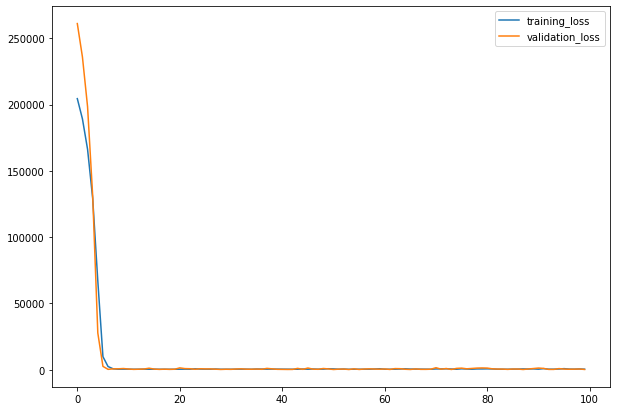

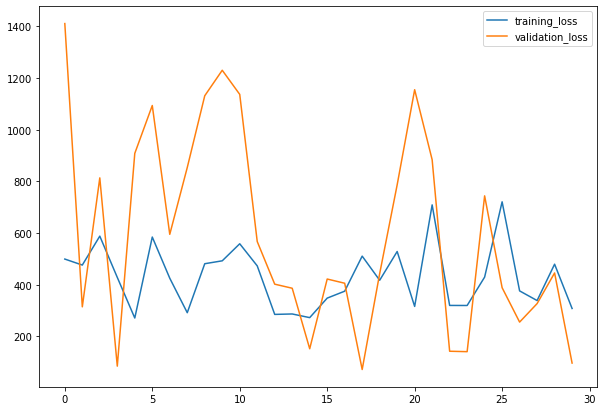

In [ ]:
plot_history(history, zoom = True)

In [ ]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions
     

In [ ]:
model_1_preds = make_preds(model_1, test_windows)

6/6 [==============================] - 0s 3ms/step


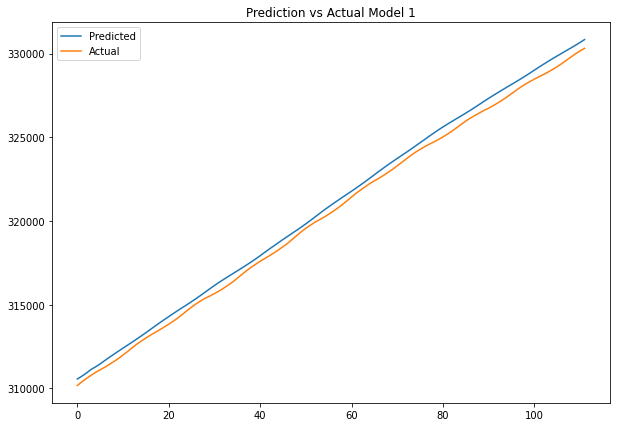

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(model_1_preds[50:], label = 'Predicted')
plt.plot(tf.squeeze(test_labels)[50:], label = 'Actual')
plt.title('Prediction vs Actual Model 1')
plt.legend();

In [ ]:
evaluate_preds(tf.squeeze(test_labels), model_1_preds)

{'mae': 343.9479, 'mse': 149989.38, 'rmse': 387.2846, 'mape': 0.10767857}

In [ ]:
def build_model(hp):
    inputs = tf.keras.layers.Input(shape=(WINDOW_SIZE))
    x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
    x = tf.keras.layers.LSTM(hp.Int('units', min_value=16, max_value=128, step =16 ), activation="relu",return_sequences=True, recurrent_dropout=0.1)(x) # using the tanh loss function results in a massive error
    x = tf.keras.layers.LSTM(hp.Int('units', min_value=32, max_value=256, step =64), activation="relu",return_sequences=True, recurrent_dropout=0.1)(x)
    output = tf.keras.layers.Dense(HORIZON)(x)
    model_1 = tf.keras.Model(inputs=inputs, outputs=output, name="model_1_lstm")

    model_1.compile(loss="mae",
                  optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values = [1e-3, 1.5e-3, 1e-4])),
                  metrics=['mae'])
    return model_1


In [ ]:
tuner = RandomSearch(build_model, objective='loss', max_trials=50, executions_per_trial=3, directory='my_dir',
                                 project_name='exp1')
tuner.search_space_summary()
tuner.search(train_windows, train_labels, epochs=100, verbose=0)
tuner.results_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': None}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0015, 0.0001], 'ordered': True}


Results summary
Results in my_dir/exp1
Showing 10 best trials
Trial summary
Hyperparameters:
units: 32
learning_rate: 0.001
Score: 193.1665802001953
Trial summary
Hyperparameters:
units: 96
learning_rate: 0.0001
Score: 193.9837443033854
Trial summary
Hyperparameters:
units: 112
learning_rate: 0.0001
Score: 196.62564086914062
Trial summary
Hyperparameters:
units: 80
learning_rate: 0.0001
Score: 197.7218221028646
Trial summary
Hyperparameters:
units: 128
learning_rate: 0.0001
Score: 214.41035970052084
Trial summary
Hyperparameters:
units: 32
learning_rate: 0.0001
Score: 220.35211690266928
Trial summary
Hyperparameters:
units: 48
learning_rate: 0.001
Score: 227.55897013346353
Trial summary
Hyperparameters:
units: 64
learning_rate: 0.0015
Score: 231.85338338216147
Trial summary
Hyperparameters:
units: 80
learning_rate: 0.001
Score: 236.49966430664062
Trial summary
Hyperparameters:
units: 48
learning_rate: 0.0015
Score: 242.7906697591146


In [ ]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.build(input_shape=(WINDOW_SIZE))
best_model.summary()

Model: "model_1_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 lambda (Lambda)             (None, 1, 10)             0         
                                                                 
 lstm (LSTM)                 (None, 1, 32)             5504      
                                                                 
 lstm_1 (LSTM)               (None, 1, 32)             8320      
                                                                 
 dense (Dense)               (None, 1, 1)              33        
                                                                 
Total params: 13,857
Trainable params: 13,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
best_model.evaluate(test_windows, test_labels)

6/6 [==============================] - 1s 3ms/step - loss: 206.8304 - mae: 206.8304


[206.8304443359375, 206.8304443359375]

In [ ]:
best_model_preds = make_preds(best_model, test_windows)

6/6 [==============================] - 0s 3ms/step


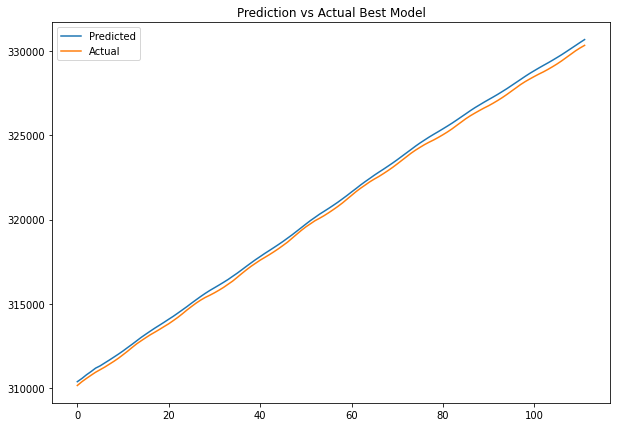

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(best_model_preds[50:], label = 'Predicted')
plt.plot(tf.squeeze(test_labels)[50:], label = 'Actual')
plt.title('Prediction vs Actual Best Model')
plt.legend();

In [ ]:
evaluate_preds(tf.squeeze(test_labels), best_model_preds)

{'mae': 206.83044, 'mse': 54229.457, 'rmse': 232.8722, 'mape': 0.06474444}

In [ ]:
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:

  future_forecast = []
  last_window = values[-WINDOW_SIZE:] 

  for _ in range(into_future):
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    future_forecast.append(tf.squeeze(future_pred).numpy())
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast
     

In [ ]:
future_forecast = make_future_forecast(values=test_labels,
                                       model=best_model,
                                       into_future=10,
                                       window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 15ms/step


In [ ]:
future_forecast

[330812.47,
 331112.9,
 331370.66,
 331617.72,
 331911.78,
 332130.75,
 332381.4,
 332613.38,
 332865.53,
 333065.84]

In [ ]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
dates = df.index
print(dates[-1])
def get_dates(into_future):
  future_dates = []
  last_date = dates[-1]
  #future_dates.append(last_date)
  for i in range(into_future):
    last_date = last_date + relativedelta(months=1)
    future_dates.append(last_date)
  return future_dates 

2019-12-01 00:00:00


In [ ]:
future_dates = get_dates(10)
future_dates

[Timestamp('2020-01-01 00:00:00'),
 Timestamp('2020-02-01 00:00:00'),
 Timestamp('2020-03-01 00:00:00'),
 Timestamp('2020-04-01 00:00:00'),
 Timestamp('2020-05-01 00:00:00'),
 Timestamp('2020-06-01 00:00:00'),
 Timestamp('2020-07-01 00:00:00'),
 Timestamp('2020-08-01 00:00:00'),
 Timestamp('2020-09-01 00:00:00'),
 Timestamp('2020-10-01 00:00:00')]

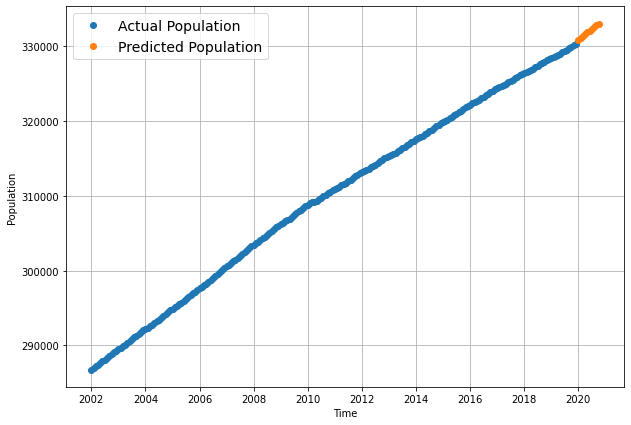

In [ ]:
# Plot future US Population
plt.figure(figsize=(10, 7))
plot_time_series(df.index, df, start=600, format="o", label="Actual Population")
plot_time_series(future_dates, future_forecast, format="o", label="Predicted Population")